In [0]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#root_dir = "/content/gdrive/My Drive/"
#gdrive_dir = root_dir + 'fastai/'

In [98]:

num_classes = 2   # number of output classes discrete range [0,9]
num_epochs  = 20    # number of times the entire dataset is presented to the model
batch_size  = 15   # the size of input data took for one iteration
lr          = 1e-3 # size of step

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
!wget "https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar"
!tar -xvf 'wildfire_smoke_data.tar'

--2020-01-31 06:50:03--  https://www.dropbox.com/s/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar [following]
--2020-01-31 06:50:04--  https://www.dropbox.com/s/raw/ghfhjtoh1z59xeb/wildfire_smoke_data.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf93e5f37042fb25248b1f254ef.dl.dropboxusercontent.com/cd/0/inline/AxMNntAwIk32HFfQmD-w6swYA8gTGmjLsQ9YhMwWTkGPo6t447LDFNJ92gcW5EV3_PM_HDdVlglNV9rIndFlsr-4-TSWwtYvUVlFWlxh1FFGPZY_Br-YZubUukHb7zHakO8/file# [following]
--2020-01-31 06:50:04--  https://ucf93e5f37042fb25248b1f254ef.dl.dropboxusercontent.com/cd/0/inline/AxMNntAwIk32HFfQmD-w6swYA8gTGmjLsQ9YhMwWTkGPo6t447LDFNJ92gcW5EV3_PM_HDdVlglNV9

In [0]:
train_input_folder ='wildfire_smoke_data/train'
validate_input_folder = 'wildfire_smoke_data/validate'
test_input_folder = 'wildfire_smoke_data/test'


In [106]:
!ls wildfire_smoke_data/train


no_smoke  smoke


In [107]:
smoke_filenames = get_files(train_input_folder + '/smoke')
no_smoke_filenames = get_files(train_input_folder + '/no_smoke')
print(len(smoke_filenames),len(no_smoke_filenames))
smoke_img = open_image(smoke_filenames[0])
smoke_img.size

574 500


torch.Size([2048, 3072])

In [0]:
tfms = get_transforms()
data = (ImageList
        .from_folder('wildfire_smoke_data/train')
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms,size=(256,256))
        .databunch(bs=64)
        .normalize(imagenet_stats)
)

In [0]:
data.show_batch(rows=3,figsize=(12,10))

In [132]:
# loading imagenet pre-trained model, also using mix precision for training 
learn = cnn_learner(data,models.resnet34,metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 233MB/s]


In [133]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

In [134]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


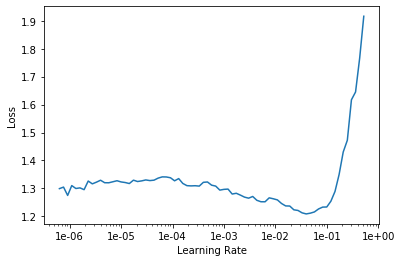

In [135]:
learn.recorder.plot()

In [136]:
lr = 3e-3
learn.fit_one_cycle(3,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.327035,0.917283,0.663551,01:55
1,1.206316,0.637966,0.789720,01:53
2,1.092809,0.674768,0.752336,01:54


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05
Min loss divided by 10: 2.75E-05


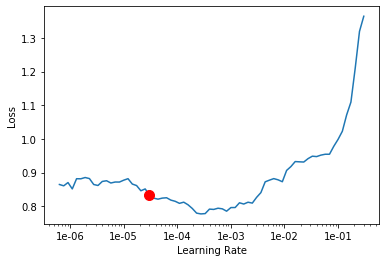

In [138]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.save('resnet34-stage-1-256')

In [140]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.888078,0.484215,0.742991,01:53
1,0.789693,0.456798,0.808411,01:52
2,0.704494,0.303886,0.869159,01:52
3,0.616787,0.251320,0.906542,01:53
4,0.563988,0.259031,0.911215,01:53


In [0]:
data_512 = (ImageList
        .from_folder(train_input_folder,include=['smoke','no_smoke'])
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms,size=(512,512))
        .databunch(bs=64)
        .normalize(imagenet_stats)
)

In [0]:
learn.data = data_512
learn.freeze_to(-1)
#learn.to_fp16();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-03


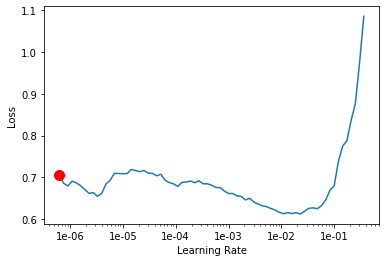

In [143]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [144]:
lr = 1e-3
learn.fit_one_cycle(3,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.688285,0.480667,0.799065,02:49
1,0.627948,0.327748,0.845794,02:49
2,0.594581,0.341091,0.855140,02:47


In [0]:
learn.unfreeze()
learn.save('res34-stage-1-512')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-05


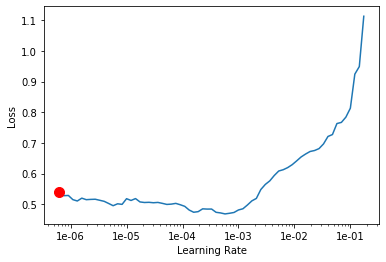

In [146]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [27]:
learn.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.477203,0.415562,0.803738,02:56
1,0.472168,0.341509,0.873832,03:08
2,0.428375,0.252911,0.892523,03:10
3,0.392922,0.230114,0.934579,03:09
4,0.362056,0.202885,0.934579,03:09


In [30]:
path1 = learn.save('res34-stage-2-512',return_path=True)
print(path1)




wildfire_smoke_data/train/models/res34-stage-2-512.pth


In [0]:
learn.export('res34-stage-2-512.pkl')


In [156]:
!ls -l wildfire_smoke_data/train/res34-stage-2-512.pkl

-rw-r--r-- 1 root root 87390678 Jan 30 02:42 wildfire_smoke_data/train/res34-stage-2-512.pkl


In [158]:
files.download('wildfire_smoke_data/train/res34-stage-2-512.pkl')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 52764, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [46]:
!ls -l wildfire_smoke_data/train/



total 42844
drwxr-xr-x 2 root root      4096 Jan 28 23:00 models
drwxr-xr-x 2  501 staff    28672 Dec 24 18:42 no_smoke
-rw-r--r-- 1 root root  43804098 Jan 28 23:09 res34-stage-2-512.pkl
drwxr-xr-x 2  501 staff    32768 Jan 28 21:20 smoke


In [0]:
from google.colab import files
files.download('wildfire_smoke_data/train/res34-stage-2-512.pkl')


In [0]:
ls /content/gdrive/My\ Drive/fastai/models


In [0]:
#learn.load('res34-stage-2-512')

In [159]:
y_p, y, loss = learn.get_preds(with_loss=True)

In [160]:
y_p.shape,y.shape

(torch.Size([214, 2]), torch.Size([214]))

In [0]:
pred = y_p.argmax(dim=-1).float()

In [163]:
pred.shape

torch.Size([214])

In [164]:
from sklearn.metrics import f1_score
f1_score(y,pred)

0.8544600938967136

In [165]:
learn.show_results()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
interp = ClassificationInterpretation(learn, y_p, y, loss)

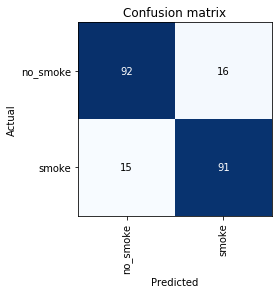

In [167]:
interp.plot_confusion_matrix()

wildfire_smoke_data/train/no_smoke/1530900961_-00720.jpg
wildfire_smoke_data/train/no_smoke/1563122167_-00420.jpg
wildfire_smoke_data/train/no_smoke/1563134063_-00960.jpg
wildfire_smoke_data/train/smoke/1529002880_+01920.jpg
wildfire_smoke_data/train/smoke/1564871259_+02040.jpg
wildfire_smoke_data/train/smoke/1532546185_+01260.jpg
wildfire_smoke_data/train/smoke/1563123727_+01140.jpg
wildfire_smoke_data/train/no_smoke/1563134663_-00360.jpg
wildfire_smoke_data/train/no_smoke/1564683282_-01919.jpg
wildfire_smoke_data/train/no_smoke/1564867659_-01560.jpg
wildfire_smoke_data/train/no_smoke/1564867179_-02040.jpg
wildfire_smoke_data/train/no_smoke/1530738865_-00180.jpg
wildfire_smoke_data/train/no_smoke/1530899701_-01980.jpg
wildfire_smoke_data/train/no_smoke/1564684241_-00960.jpg
wildfire_smoke_data/train/no_smoke/1498415013_-01380.jpg
wildfire_smoke_data/train/no_smoke/1499544883_-01380.jpg
wildfire_smoke_data/train/smoke/1499548123_+01860.jpg


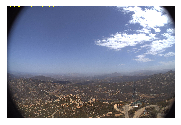

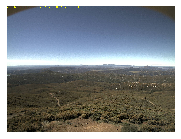

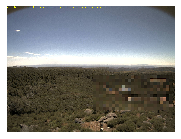

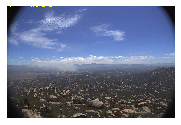

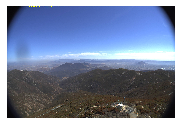

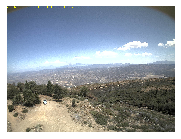

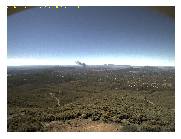

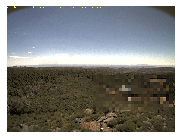

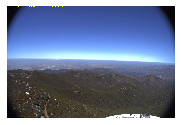

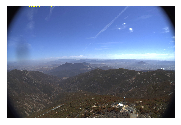

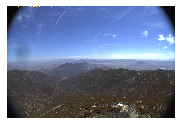

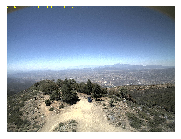

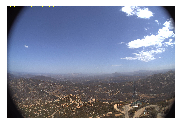

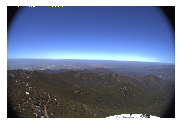

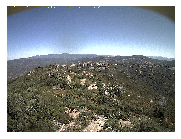

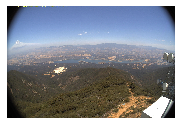

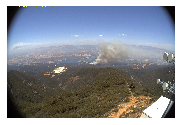

In [168]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses(17)
for p in data.valid_ds.x.items[idxs]:
  print(p)
  img=open_image(p)
  img.show()


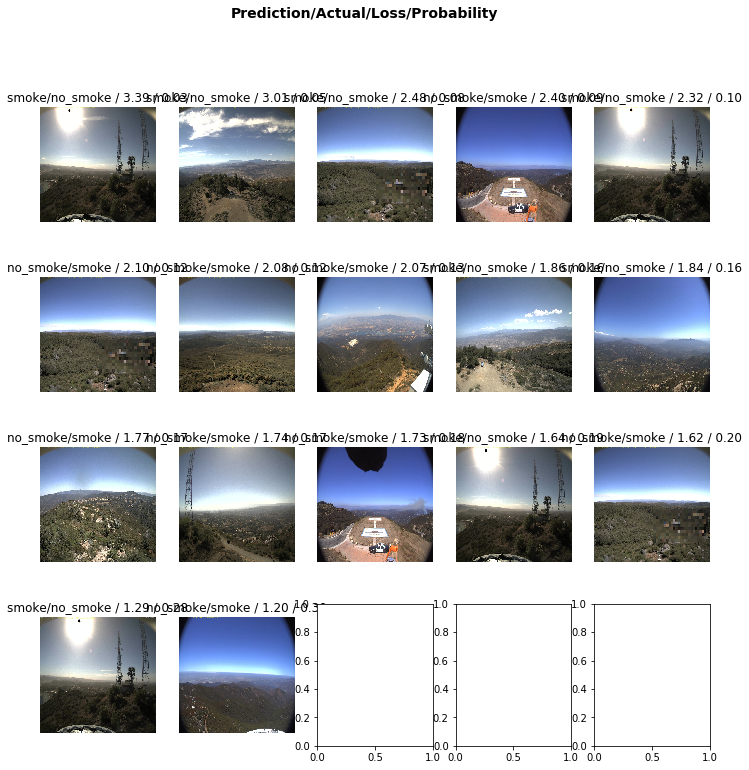

In [169]:
interp.plot_top_losses(17)

In [3]:

from google.colab import files
files.upload()

Saving res34-stage-2-512.pkl to res34-stage-2-512.pkl


In [0]:
def load_model():
    learn = load_learner('.','res34-stage-2-512.pkl')
    #learn.model.float
    return learn

In [0]:
learn= load_model()

In [170]:
img=open_image('wildfire_smoke_data/train/smoke/1559169605_+02220.jpg')
learn.predict(img)

(Category smoke, tensor(1), tensor([0.0173, 0.9827]))

Validate against test data

In [5]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1x4bzhH-ZgEUUvh45EStFNrTT_wLSPC35' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1x4bzhH-ZgEUUvh45EStFNrTT_wLSPC35" -O fuegoSmoke.zip && rm -rf /tmp/cookies.txt

--2020-01-31 05:38:11--  https://docs.google.com/uc?export=download&confirm=zBNh&id=1x4bzhH-ZgEUUvh45EStFNrTT_wLSPC35
Resolving docs.google.com (docs.google.com)... 108.177.126.102, 108.177.126.100, 108.177.126.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nsf1udo6rmsn2fh9ck5kd1p556gbts8p/1580443200000/12156571009874819823/*/1x4bzhH-ZgEUUvh45EStFNrTT_wLSPC35?e=download [following]
--2020-01-31 05:38:11--  https://doc-10-7o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nsf1udo6rmsn2fh9ck5kd1p556gbts8p/1580443200000/12156571009874819823/*/1x4bzhH-ZgEUUvh45EStFNrTT_wLSPC35?e=download
Resolving doc-10-7o-docs.googleusercontent.com (doc-10-7o-docs.googleusercontent.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to doc-10-7o-docs.googleuserconten

In [6]:
!mkdir testdata
!cp fuegoSmoke.zip testdata
%cd testdata
!unzip fuegoSmoke.zip
%cd ..


/content/testdata
Archive:  fuegoSmoke.zip
  inflating: 69bravo-e-mobo-c__2019-08-13T14;21;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;22;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;26;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;27;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;28;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;29;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;30;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;31;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;32;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;33;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;34;45.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;36;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;37;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;38;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;39;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;40;44.jpg  
  inflating: 69bravo-e-mobo-c__2019-08-13T14;

In [0]:
??

In [7]:
#learn = load_learner(mnist, test=ImageList.from_folder(mnist/'test'))
learn = load_learner('.','res34-stage-2-512.pkl',test=ImageList.from_folder('testdata'))
preds,y = learn.get_preds(ds_type=DatasetType.Test)

#values = learn.validate()

tensor([[0.7837, 0.2163],
        [0.7974, 0.2026],
        [0.8626, 0.1374],
        [0.0582, 0.9418],
        [0.9751, 0.0249]])

In [10]:
preds[:10]

tensor([[0.7837, 0.2163],
        [0.7974, 0.2026],
        [0.8626, 0.1374],
        [0.0582, 0.9418],
        [0.9751, 0.0249],
        [0.6046, 0.3954],
        [0.9510, 0.0490],
        [0.6722, 0.3278],
        [0.9647, 0.0353],
        [0.3132, 0.6868]])

In [40]:
for f in os.listdir('testdata'): 
  img=open_image('testdata/' +f)
  res = learn.predict(img)
  print(f)
  print(res)
  

lp-e-mobo-c__2019-10-06T11;15;04.jpg
(Category no_smoke, tensor(0), tensor([0.7837, 0.2163]))
sm-w-mobo-c__2019-08-25T14;30;33.jpg
(Category no_smoke, tensor(0), tensor([0.7974, 0.2026]))
sp-n-mobo-c__2019-07-28T14;10;26.jpg
(Category no_smoke, tensor(0), tensor([0.8626, 0.1374]))
smer-tcs9-mobo-c__2019-10-01T11;55;57.jpg
(Category smoke, tensor(1), tensor([0.0582, 0.9418]))
pi-s-mobo-c__2019-08-26T12;40;07.jpg
(Category no_smoke, tensor(0), tensor([0.9751, 0.0249]))
rm-w-mobo-c__2019-08-29T12;05;06.jpg
(Category no_smoke, tensor(0), tensor([0.6046, 0.3954]))
hp-n-mobo-c__2019-07-16T14;45;25.jpg
(Category no_smoke, tensor(0), tensor([0.9510, 0.0490]))
pi-s-mobo-c__2019-08-26T11;34;07.jpg
(Category no_smoke, tensor(0), tensor([0.6722, 0.3278]))
bm-e-mobo-c__2019-10-05T14;25;35.jpg
(Category no_smoke, tensor(0), tensor([0.9647, 0.0353]))
wc-s-mobo-c__2019-09-24T14;56;25.jpg
(Category smoke, tensor(1), tensor([0.3132, 0.6868]))
om-s-mobo-c__2019-10-06T11;36;39.jpg
(Category smoke, tensor(

In [41]:
!ls testdata/*.jpg | wc -l

1661


In [43]:
img=open_image('testdata/smer-tcs9-mobo-c__2019-10-01T11;55;57.jpg')
img

Output hidden; open in https://colab.research.google.com to view.